In [1]:
!pip install torch-cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp311-cp311-linux_x86_64.whl size=2064055 sha256=2934d7e16d430b658d0f73a5762d4a75b85e362a6939c8f1653bf7e570a3abd0
  Stored in directory: /root/.cache/pip/wheels/ef/de/7d/a4211822af99147b93800e9e204f0be21294e3c0b95b3b861a
Successfully built torch-cluster


In [2]:
!pip install trimesh scikit-image tqdm open3d 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 104.7 MB/s eta 0:00:0000:0100:01


## Import

In [3]:
import os
import sys
import glob
import math
import random
import numpy as np
import trimesh
from tqdm import tqdm
from skimage import measure
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import kagglehub
import plotly.graph_objects as go
import trimesh
import open3d as o3d
import plotly.graph_objects as go
from torch_cluster import knn
from torch.cuda.amp import autocast, GradScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Prepare Data, Mesh → SDF Samples 

In [4]:
local_path = "/kaggle/input/shapenetcorev2"
path = None
if os.path.exists(local_path):
    print("Found local ShapeNetCoreV2 directory!")
    path = local_path
else:
    print("Local directory not found. Downloading dataset...")
    path = kagglehub.dataset_download("hajareddagni/shapenetcorev2")
print(path)
mesh_root = path

Found local ShapeNetCoreV2 directory!
/kaggle/input/shapenetcorev2


In [5]:
CONFIG = {
    "num_complete_points": 2048,
    "num_partial_points": 2048,
    "feat_dim": 1024,
    "num_coarse": 2048,
    "num_fine": 16384,          # ← 4× increase (2048 → 16384 = 8× expansion)
    "fold_grid_size": 2,        # Still 2×2, but do 3 folding stages
    # Training
    "train_epochs": 100,        # ← 2× increase
    "batch_size": 6,
    "learning_rate": 1e-4,
    "warmup_epochs": 5,         # ← NEW: learning rate warmup
    "scheduler": "cosine",      # ← NEW: cosine annealing
    # Loss weights (fine-tuned)
    "weight_chamfer": 2.0,      # ← Increase emphasis on accuracy
    "weight_repulsion": 1.0,    # ← Reduce (avoid over-smoothing)
    "weight_density": 0.1,      # ← Increase
    "weight_boundary": 0.05,
    # Dataset
    "max_meshes": 10000,
    "hole_ratio_min": 0.2,
    "hole_ratio_max": 0.5,
}

In [6]:
# Tìm file obj trong ShapeNet
obj_paths = glob.glob(os.path.join(mesh_root, "**", "models", "*.ply"), recursive=True)
obj_paths = sorted(obj_paths)
print("Total PLY found:", len(obj_paths))
obj_paths = obj_paths[:CONFIG["max_meshes"]]
print("Using PLY:", len(obj_paths))

Total PLY found: 52472
Using PLY: 10000


### SDF samples từ mesh

In [7]:
def create_hole_in_pointcloud(complete_points, hole_ratio_min=0.2, hole_ratio_max=0.5):
    # Random center and radius for hole
    center_idx = np.random.randint(len(complete_points))
    center = complete_points[center_idx]
    
    # Random hole size
    hole_ratio = np.random.uniform(hole_ratio_min, hole_ratio_max)
    
    # Calculate distances from center
    dists = np.linalg.norm(complete_points - center, axis=1)
    radius = np.percentile(dists, hole_ratio * 100)
    
    # Keep points outside the hole
    keep_mask = dists > radius
    partial_points = complete_points[keep_mask]
    
    # Ensure minimum number of points
    if len(partial_points) < 100:
        # If hole too big, keep more points
        keep_indices = np.argsort(dists)[100:]
        partial_points = complete_points[keep_indices]
    
    return partial_points

In [8]:
def sample_point_cloud_pair(obj_path, out_path):
    try:
        mesh = trimesh.load(obj_path, force='mesh')

        # Fix mesh
        if hasattr(mesh, "repair"):
            mesh.repair.fix_normals()
            mesh.repair.fix_winding()
            mesh.repair.fill_holes()

        if not isinstance(mesh, trimesh.Trimesh):
            mesh = trimesh.util.concatenate(mesh.geometry.values())

        # Normalize mesh
        mesh.apply_translation(-mesh.center_mass)
        mesh.apply_scale(1.0 / np.max(mesh.extents))

        # Sample complete
        complete_points = mesh.sample(CONFIG["num_complete_points"])

        # Partial with hole
        partial_points = create_hole_in_pointcloud(
            complete_points,
            CONFIG["hole_ratio_min"],
            CONFIG["hole_ratio_max"]
        )

        # Save
        np.savez_compressed(
            out_path,
            complete=complete_points.astype(np.float32),
            partial=partial_points.astype(np.float32)
        )

    except Exception as e:
        print("Error at:", obj_path, "->", e)
        raise e

In [9]:
!rm -rf pointcloud_data
os.makedirs("pointcloud_data", exist_ok=True)

pc_paths = []
for obj in tqdm(obj_paths, desc="Sampling Point Clouds"):
    name = os.path.splitext(os.path.basename(obj))[0]
    outp = f"pointcloud_data/{name}.npz"

    if not os.path.exists(outp):
        try:
            sample_point_cloud_pair(obj, outp)
        except Exception as e:
            print("Failed:", obj, e)
            continue

    pc_paths.append(outp)

print("Point cloud files:", len(pc_paths))

Sampling Point Clouds: 100%|██████████| 10000/10000 [00:00<00:00, 50461.80it/s]

Point cloud files: 10000


# Chuẩn bị dataset

In [10]:
def normalize_pair(partial, complete):
    centroid = complete.mean(axis=0, keepdims=True)
    complete = complete - centroid
    partial = partial - centroid

    scale = np.max(np.linalg.norm(complete, axis=1))
    complete = complete / (scale + 1e-9)
    partial = partial / (scale + 1e-9)
    return partial, complete

In [11]:
class PointCloudCompletionDataset(Dataset):
    def __init__(self, npz_paths, num_partial=2048, num_complete=2048, augment=True):
        self.paths = npz_paths
        self.num_partial = num_partial      
        self.num_complete = num_complete
        self.augment = augment
    def __len__(self):
        return len(self.paths)

    def _resample(self, pts, n, replace=True):
        N = pts.shape[0]
        if N == 0:
            return np.zeros((n,3), dtype=np.float32)
        if N >= n:
            sel = np.random.choice(N, n, replace=False)
        else:
            sel = np.random.choice(N, n, replace=True)
        return pts[sel]

    def __getitem__(self, idx):
        data = np.load(self.paths[idx])
        partial = data['partial']    # (P,3)
        complete = data['complete']  # (C,3)
        partial, complete = normalize_pair(partial, complete)
        # random rotation augmentation (optional)
        if self.augment:
            theta = np.random.uniform(0, 2*np.pi)
            R = np.array([[np.cos(theta), -np.sin(theta), 0],
                          [np.sin(theta),  np.cos(theta), 0],
                          [0, 0, 1]], dtype=np.float32)
            partial  = partial.dot(R.T)
            complete = complete.dot(R.T)
    
        # Resample
        partial  = self._resample(partial,  self.num_partial)
        complete = self._resample(complete, self.num_complete)
    
        return torch.from_numpy(partial).float(), torch.from_numpy(complete).float()

## Model Architecture 

In [12]:
class PointNetEncoder(nn.Module):
    def __init__(self, feat_dim=1024):
        super().__init__()
        # Deeper architecture: 3 → 64 → 128 → 256 → 512 → 1024
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)   
        self.conv4 = nn.Conv1d(256, 512, 1)   
        self.conv5 = nn.Conv1d(512, feat_dim, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)         
        self.bn4 = nn.BatchNorm1d(512)        
        self.bn5 = nn.BatchNorm1d(feat_dim)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))    
        x = F.relu(self.bn4(self.conv4(x)))   
        x = self.bn5(self.conv5(x))
        x = torch.max(x, dim=2)[0]
        x = self.dropout(x)                     
        return x

In [13]:
class CoarseDecoder(nn.Module):
    def __init__(self, feat_dim=1024, num_coarse=1024):
        super().__init__()
        self.fc1 = nn.Linear(feat_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, num_coarse * 3)

        self.ln1 = nn.LayerNorm(1024)
        self.ln2 = nn.LayerNorm(1024)

        self.num_coarse = num_coarse

    def forward(self, feat):
        x = F.relu(self.ln1(self.fc1(feat)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.fc3(x)
        return x.view(-1, self.num_coarse, 3)

In [14]:
class FoldingRefinement(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 512, 1)
        self.gn1 = nn.GroupNorm(32, 512)
        self.conv2 = nn.Conv1d(512, 512, 1)
        self.gn2 = nn.GroupNorm(32, 512)
        self.conv3 = nn.Conv1d(512, 3, 1)

    def forward(self, x):
        # x: (B, C, P)
        x = F.relu(self.gn1(self.conv1(x)))
        x = F.relu(self.gn2(self.conv2(x)))
        x = self.conv3(x)  # (B, 3, P)
        return x

In [15]:
class TransformerPointNetEncoder(nn.Module):
    def __init__(self, feat_dim=1024):
        super().__init__()
        
        # PointNet backbone
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.conv4 = nn.Conv1d(256, 512, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(512)
        
        # Self-attention on point features
        self.self_attn = nn.MultiheadAttention(
            embed_dim=512,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Final projection
        self.conv5 = nn.Conv1d(512, feat_dim, 1)
        self.bn5 = nn.BatchNorm1d(feat_dim)
    
    def forward(self, x):
        # x: (B, N, 3)
        B, N, _ = x.shape
        
        x = x.transpose(2, 1)  # (B, 3, N)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))  # (B, 512, N)
        
        # Self-attention
        x_attn = x.transpose(2, 1)  # (B, N, 512)
        x_attn, _ = self.self_attn(x_attn, x_attn, x_attn)
        x = x + x_attn.transpose(2, 1)  # Residual connection
        
        # Global and local features
        feat_local = x.transpose(2, 1)  # (B, N, 512) - per-point features
        
        x = self.bn5(self.conv5(x))
        feat_global = torch.max(x, dim=2)[0]  # (B, feat_dim) - global feature
        
        return feat_global, feat_local

In [16]:
class PCN(nn.Module):
    def __init__(self, feat_dim=1024, num_coarse=2048):
        super().__init__()

        self.encoder = TransformerPointNetEncoder(feat_dim)

        self.coarse_decoder = CoarseDecoder(feat_dim, num_coarse)

        # refine + folding
        self.folding1 = FoldingRefinement(feat_dim + 3 + 2)
        self.folding2 = FoldingRefinement(feat_dim + 3 + 2)
        self.folding3 = FoldingRefinement(feat_dim + 3 + 2)
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=feat_dim,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        # MLP refine coarse
        self.refine_mlp = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

        # Convert coarse (B,N,3) → (B,N,feat_dim) để làm query
        self.coarse_feat_mlp = nn.Linear(3, feat_dim)

        # Convert local features 512 → 1024
        self.project_partial_feat = nn.Linear(512, feat_dim)
    def forward(self, partial):
        B = partial.shape[0]

        feat_global, feat_local = self.encoder(partial)
        feat_local = self.project_partial_feat(feat_local)   # (B, N, 1024)

        coarse = self.coarse_decoder(feat_global)            # (B, Nc, 3)

        coarse_ref = self.refine_with_attention(coarse, partial, feat_local)

        fine1 = self.expand_and_fold(feat_global, coarse_ref)
        fine2 = self.expand_and_fold(feat_global, fine1)
        fine3 = self.expand_and_fold(feat_global, fine2)

        return coarse, fine1, fine2, fine3
    def refine_with_attention(self, coarse, partial, partial_feat):
        B, Nc, _ = coarse.shape

        # Map (B,Nc,3) → (B,Nc,1024)
        coarse_feat = self.coarse_feat_mlp(coarse)

        refined_feat, _ = self.cross_attn(
            query=coarse_feat,
            key=partial_feat,
            value=partial_feat
        )

        delta = self.refine_mlp(refined_feat)
        return coarse + delta
    def expand_and_fold(self, feat_global, coarse_points):
        B, Nc, _ = coarse_points.shape

        # tạo grid 2D để folding
        grid = self.build_grid(B, Nc).to(feat_global.device)   # (B,2,Nc)

        # expand global feature
        feat_global_expand = feat_global.unsqueeze(2).repeat(1, 1, Nc)  # (B,1024,Nc)

        # combine
        feat = torch.cat([
            feat_global_expand,           # (B,1024,Nc)
            coarse_points.transpose(2,1), # (B,3,Nc)
            grid                          # (B,2,Nc)
        ], dim=1)

        fine = self.folding1(feat)
        return fine.transpose(2,1)        # → (B,Nc,3)
    def build_grid(self, B, P):
        s = int(math.sqrt(P)) + 1
        x = torch.linspace(-1, 1, steps=s)
        y = torch.linspace(-1, 1, steps=s)
        grid = torch.stack(torch.meshgrid(x, y, indexing='ij'), dim=0)
        grid = grid.reshape(2, -1)[:, :P]   # CẮT VỀ ĐÚNG P
        return grid.unsqueeze(0).repeat(B, 1, 1)

## Loss functions

In [17]:
def chamfer_distance(pred, gt):
    # pred: (B, N, 3), gt: (B, M, 3)
    dmat = torch.cdist(pred, gt, p=2)  # (B, N, M)
    d1 = torch.min(dmat, dim=2)[0]     # (B, N)
    d2 = torch.min(dmat, dim=1)[0]     # (B, M)
    return (d1.mean(dim=1) + d2.mean(dim=1)).mean()

In [18]:
def repulsion_loss(pred, partial=None, k=10, h=0.07):
    B, N, _ = pred.shape
    rep_all = 0.0

    for b in range(B):
        idx = knn(pred[b], pred[b], k=k+1)[1]  # k+1 vì điểm đầu tiên là chính nó
        idx = idx.reshape(N, k+1)[:, 1:]       # bỏ self-index
        
        neigh = pred[b][idx]                   # (N, k, 3)
        center = pred[b].unsqueeze(1)          # (N, 1, 3)
        d = torch.norm(center - neigh, dim=2)  # (N, k)

        rep = F.relu(h - d)

        if partial is not None:
            dist_in = torch.cdist(pred[b].unsqueeze(0), partial[b].unsqueeze(0))[0]
            weight = 1 + 3*(dist_in.min(dim=1)[0] > 0.08)
            rep = rep * weight.unsqueeze(-1)

        rep_all += rep.mean()

    return rep_all / B

In [19]:
def density_loss(pred, gt, bandwidth=0.02, sample_ratio=0.1):
    B, M, _ = gt.shape
    S = max(32, int(M * sample_ratio))
    idx = torch.randint(0, M, (S,), device=pred.device)
    sample = gt[:, idx, :]
    d_pred = torch.cdist(sample, pred, p=2)
    d_gt   = torch.cdist(sample, gt, p=2)
    k_pred = torch.exp(-d_pred**2 / (2 * bandwidth**2)).mean(dim=2)
    k_gt   = torch.exp(-d_gt**2 / (2 * bandwidth**2)).mean(dim=2)
    return ((k_pred - k_gt)**2).mean()

In [20]:
def boundary_aware_loss(pred_fine, partial, alpha=2.0):
    dist_to_input = torch.cdist(pred_fine, partial)  # (B, N_fine, N_partial)
    min_dist, _ = torch.min(dist_to_input, dim=2)   # (B, N_fine)
    boundary_penalty = F.relu(min_dist - 0.1).pow(alpha)
    return boundary_penalty.mean()

In [21]:
def combined_loss(pred_coarse, pred_fine1, pred_fine2, pred_fine3, gt, partial, weights=None):
    if weights is None:
        weights = {
            'chamfer': 2.0,
            'repulsion': 1.0,
            'density': 0.1,
            'boundary': 0.05
        }
    # Progressive supervision
    loss_chamfer = (
        0.1 * chamfer_distance(pred_coarse, gt) +
        0.2 * chamfer_distance(pred_fine1, gt) +
        0.3 * chamfer_distance(pred_fine2, gt) +
        1.0 * chamfer_distance(pred_fine3, gt)
    )
    loss_rep = repulsion_loss(pred_fine3, partial=partial, k=10, h=0.05)  # ← Stricter h
    loss_den = density_loss(pred_fine3, gt, bandwidth=0.015, sample_ratio=0.3)  # ← Finer
    loss_boundary = boundary_aware_loss(pred_fine3, partial, alpha=2.0)
    
    total = (
        weights['chamfer'] * loss_chamfer +
        weights['repulsion'] * loss_rep +
        weights['density'] * loss_den +
        weights['boundary'] * loss_boundary
    )
    
    return total, {
        'chamfer': loss_chamfer.item(),
        'repulsion': loss_rep.item(),
        'density': loss_den.item(),
        'boundary': loss_boundary.item()
    }

In [22]:
def train(model, dataloader, epochs=50, device="cuda"):
    model = model.to(device)
    
    # AdamW with weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )
    
    # Cosine annealing with warmup
    from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
    
    def warmup_lambda(epoch):
        if epoch < 5:
            return (epoch + 1) / 5
        return 1.0
    
    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=epochs-5, eta_min=1e-6)
    
    scaler = GradScaler(enabled=True)
    best_loss = float('inf')
    
    for epoch in range(1, epochs + 1):
        model.train()
        loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}")
        
        epoch_loss = 0
        steps = 0
        
        for partial, complete in loop:
            partial = partial.to(device, non_blocking=True)
            complete = complete.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            with autocast(enabled=True):
                coarse, fine1, fine2, fine3 = model(partial)
                loss, loss_dict = combined_loss(
                    coarse, fine1, fine2, fine3, 
                    complete, partial
                )
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()
            steps += 1
            
            loop.set_postfix({"Loss": f"{epoch_loss/steps:.4f}"})
        
        # Learning rate scheduling
        if epoch <= 5:
            warmup_scheduler.step()
        else:
            cosine_scheduler.step()
        
        avg_loss = epoch_loss / steps
        print(f"Epoch {epoch}: Loss = {avg_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, f'pcn_improved_v1_best.pth')
            print(f"✓ Saved best model (loss: {best_loss:.6f})")
    
    return model

### Training loop

In [23]:
def compute_grid_size(num_coarse, num_fine):
    ratio = num_fine // num_coarse
    G = int(math.sqrt(ratio))
    if G * G != ratio:
        raise ValueError(
            f"[Invalid PCN config] num_fine must equal num_coarse * G*G.\n"
            f"Given num_coarse={num_coarse}, num_fine={num_fine} → ratio={ratio}.\n"
            f"But {G}x{G}={G*G} ≠ {ratio}.\n"
            f"Valid examples: (1024→4096), (512→2048), (2048→8192)..."
        )
    return G

In [25]:
pcs = sorted(glob.glob("pointcloud_data/*.npz"))
assert len(pcs) > 0, "No pointcloud_data/*.npz found. Create them first."
pcs = pcs[: CONFIG["max_meshes"]]
ds = PointCloudCompletionDataset(
    pc_paths,
    num_partial=CONFIG["num_partial_points"],
    num_complete=CONFIG["num_complete_points"],
    augment=True
)
dl = DataLoader(
    ds,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=2,
    drop_last=False
)
#G = compute_grid_size(CONFIG["num_coarse"], CONFIG["num_fine"])
model = PCN(
    feat_dim=CONFIG["feat_dim"],
    num_coarse=CONFIG["num_coarse"],
).to(device)
opt = torch.optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
train(model, dl, epochs=CONFIG["train_epochs"], device=device)

/tmp/ipykernel_47/739499920.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
Epoch 1/100:   0%|          | 0/1667 [00:00<?, ?it/s]/tmp/ipykernel_47/739499920.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 1/100: 100%|██████████| 1667/1667 [11:17<00:00,  2.46it/s, Loss=0.8272]


Epoch 1: Loss = 0.827181, LR = 0.000040
✓ Saved best model (loss: 0.827181)


Epoch 2/100: 100%|██████████| 1667/1667 [11:04<00:00,  2.51it/s, Loss=0.3727]


Epoch 2: Loss = 0.372747, LR = 0.000060
✓ Saved best model (loss: 0.372747)


Epoch 3/100: 100%|██████████| 1667/1667 [11:02<00:00,  2.52it/s, Loss=0.2865]


Epoch 3: Loss = 0.286488, LR = 0.000080
✓ Saved best model (loss: 0.286488)


Epoch 4/100: 100%|██████████| 1667/1667 [11:02<00:00,  2.52it/s, Loss=0.2518]


Epoch 4: Loss = 0.251803, LR = 0.000100
✓ Saved best model (loss: 0.251803)


Epoch 5/100: 100%|██████████| 1667/1667 [10:58<00:00,  2.53it/s, Loss=0.2305]


Epoch 5: Loss = 0.230488, LR = 0.000100
✓ Saved best model (loss: 0.230488)


Epoch 6/100: 100%|██████████| 1667/1667 [10:56<00:00,  2.54it/s, Loss=0.2089]


Epoch 6: Loss = 0.208924, LR = 0.000100
✓ Saved best model (loss: 0.208924)


Epoch 7/100: 100%|██████████| 1667/1667 [10:53<00:00,  2.55it/s, Loss=0.1942]


Epoch 7: Loss = 0.194169, LR = 0.000100
✓ Saved best model (loss: 0.194169)


Epoch 8/100: 100%|██████████| 1667/1667 [10:51<00:00,  2.56it/s, Loss=0.1853]


Epoch 8: Loss = 0.185266, LR = 0.000100
✓ Saved best model (loss: 0.185266)


Epoch 9/100: 100%|██████████| 1667/1667 [10:50<00:00,  2.56it/s, Loss=0.1776]


Epoch 9: Loss = 0.177593, LR = 0.000100
✓ Saved best model (loss: 0.177593)


Epoch 10/100: 100%|██████████| 1667/1667 [10:49<00:00,  2.57it/s, Loss=0.1729]


Epoch 10: Loss = 0.172858, LR = 0.000099
✓ Saved best model (loss: 0.172858)


Epoch 11/100: 100%|██████████| 1667/1667 [10:47<00:00,  2.57it/s, Loss=0.1678]


Epoch 11: Loss = 0.167764, LR = 0.000099
✓ Saved best model (loss: 0.167764)


Epoch 12/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1624]


Epoch 12: Loss = 0.162400, LR = 0.000099
✓ Saved best model (loss: 0.162400)


Epoch 13/100: 100%|██████████| 1667/1667 [10:45<00:00,  2.58it/s, Loss=0.1598]


Epoch 13: Loss = 0.159807, LR = 0.000098
✓ Saved best model (loss: 0.159807)


Epoch 14/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1569]


Epoch 14: Loss = 0.156910, LR = 0.000098
✓ Saved best model (loss: 0.156910)


Epoch 15/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1540]


Epoch 15: Loss = 0.154026, LR = 0.000097
✓ Saved best model (loss: 0.154026)


Epoch 16/100: 100%|██████████| 1667/1667 [10:44<00:00,  2.59it/s, Loss=0.1524]


Epoch 16: Loss = 0.152442, LR = 0.000097
✓ Saved best model (loss: 0.152442)


Epoch 17/100: 100%|██████████| 1667/1667 [10:44<00:00,  2.59it/s, Loss=0.1496]


Epoch 17: Loss = 0.149649, LR = 0.000096
✓ Saved best model (loss: 0.149649)


Epoch 18/100: 100%|██████████| 1667/1667 [10:43<00:00,  2.59it/s, Loss=0.1496]


Epoch 18: Loss = 0.149573, LR = 0.000095
✓ Saved best model (loss: 0.149573)


Epoch 19/100: 100%|██████████| 1667/1667 [10:43<00:00,  2.59it/s, Loss=0.1460]


Epoch 19: Loss = 0.146005, LR = 0.000095
✓ Saved best model (loss: 0.146005)


Epoch 20/100: 100%|██████████| 1667/1667 [10:42<00:00,  2.59it/s, Loss=0.1454]


Epoch 20: Loss = 0.145410, LR = 0.000094
✓ Saved best model (loss: 0.145410)


Epoch 21/100: 100%|██████████| 1667/1667 [10:42<00:00,  2.59it/s, Loss=0.1445]


Epoch 21: Loss = 0.144476, LR = 0.000093
✓ Saved best model (loss: 0.144476)


Epoch 22/100: 100%|██████████| 1667/1667 [10:42<00:00,  2.59it/s, Loss=0.1414]


Epoch 22: Loss = 0.141391, LR = 0.000092
✓ Saved best model (loss: 0.141391)


Epoch 23/100: 100%|██████████| 1667/1667 [10:41<00:00,  2.60it/s, Loss=0.1403]


Epoch 23: Loss = 0.140300, LR = 0.000091
✓ Saved best model (loss: 0.140300)


Epoch 24/100: 100%|██████████| 1667/1667 [10:40<00:00,  2.60it/s, Loss=0.1386]


Epoch 24: Loss = 0.138649, LR = 0.000091
✓ Saved best model (loss: 0.138649)


Epoch 25/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1388]


Epoch 25: Loss = 0.138833, LR = 0.000090


Epoch 26/100: 100%|██████████| 1667/1667 [10:42<00:00,  2.59it/s, Loss=0.1367]


Epoch 26: Loss = 0.136693, LR = 0.000089
✓ Saved best model (loss: 0.136693)


Epoch 27/100: 100%|██████████| 1667/1667 [10:42<00:00,  2.60it/s, Loss=0.1352]


Epoch 27: Loss = 0.135167, LR = 0.000087
✓ Saved best model (loss: 0.135167)


Epoch 28/100: 100%|██████████| 1667/1667 [10:41<00:00,  2.60it/s, Loss=0.1339]


Epoch 28: Loss = 0.133926, LR = 0.000086
✓ Saved best model (loss: 0.133926)


Epoch 29/100: 100%|██████████| 1667/1667 [10:40<00:00,  2.60it/s, Loss=0.1328]


Epoch 29: Loss = 0.132837, LR = 0.000085
✓ Saved best model (loss: 0.132837)


Epoch 30/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1336]


Epoch 30: Loss = 0.133555, LR = 0.000084


Epoch 31/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1317]


Epoch 31: Loss = 0.131675, LR = 0.000083
✓ Saved best model (loss: 0.131675)


Epoch 32/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1303]


Epoch 32: Loss = 0.130337, LR = 0.000082
✓ Saved best model (loss: 0.130337)


Epoch 33/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1287]


Epoch 33: Loss = 0.128711, LR = 0.000080
✓ Saved best model (loss: 0.128711)


Epoch 34/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1278]


Epoch 34: Loss = 0.127796, LR = 0.000079
✓ Saved best model (loss: 0.127796)


Epoch 35/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1272]


Epoch 35: Loss = 0.127151, LR = 0.000078
✓ Saved best model (loss: 0.127151)


Epoch 36/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1262]


Epoch 36: Loss = 0.126163, LR = 0.000076
✓ Saved best model (loss: 0.126163)


Epoch 37/100: 100%|██████████| 1667/1667 [10:41<00:00,  2.60it/s, Loss=0.1253]


Epoch 37: Loss = 0.125332, LR = 0.000075
✓ Saved best model (loss: 0.125332)


Epoch 38/100: 100%|██████████| 1667/1667 [10:39<00:00,  2.61it/s, Loss=0.1248]


Epoch 38: Loss = 0.124831, LR = 0.000073
✓ Saved best model (loss: 0.124831)


Epoch 39/100: 100%|██████████| 1667/1667 [10:42<00:00,  2.59it/s, Loss=0.1232]


Epoch 39: Loss = 0.123244, LR = 0.000072
✓ Saved best model (loss: 0.123244)


Epoch 40/100: 100%|██████████| 1667/1667 [10:43<00:00,  2.59it/s, Loss=0.1224]


Epoch 40: Loss = 0.122395, LR = 0.000070
✓ Saved best model (loss: 0.122395)


Epoch 41/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1216]


Epoch 41: Loss = 0.121627, LR = 0.000069
✓ Saved best model (loss: 0.121627)


Epoch 42/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1213]


Epoch 42: Loss = 0.121262, LR = 0.000067
✓ Saved best model (loss: 0.121262)


Epoch 43/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1206]


Epoch 43: Loss = 0.120566, LR = 0.000066
✓ Saved best model (loss: 0.120566)


Epoch 44/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1195]


Epoch 44: Loss = 0.119522, LR = 0.000064
✓ Saved best model (loss: 0.119522)


Epoch 45/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1186]


Epoch 45: Loss = 0.118593, LR = 0.000063
✓ Saved best model (loss: 0.118593)


Epoch 46/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1185]


Epoch 46: Loss = 0.118474, LR = 0.000061
✓ Saved best model (loss: 0.118474)


Epoch 47/100: 100%|██████████| 1667/1667 [10:45<00:00,  2.58it/s, Loss=0.1175]


Epoch 47: Loss = 0.117516, LR = 0.000059
✓ Saved best model (loss: 0.117516)


Epoch 48/100: 100%|██████████| 1667/1667 [10:45<00:00,  2.58it/s, Loss=0.1165]


Epoch 48: Loss = 0.116534, LR = 0.000058
✓ Saved best model (loss: 0.116534)


Epoch 49/100: 100%|██████████| 1667/1667 [10:45<00:00,  2.58it/s, Loss=0.1163]


Epoch 49: Loss = 0.116263, LR = 0.000056
✓ Saved best model (loss: 0.116263)


Epoch 50/100: 100%|██████████| 1667/1667 [10:46<00:00,  2.58it/s, Loss=0.1147]


Epoch 50: Loss = 0.114670, LR = 0.000055
✓ Saved best model (loss: 0.114670)


Epoch 51/100:  21%|██        | 350/1667 [02:15<08:31,  2.57it/s, Loss=0.1153]


KeyboardInterrupt: 

# Checkpoints

In [31]:
def load_model_from_checkpoint(checkpoint_path, device, CONFIG):
    model = PCN(
        feat_dim=CONFIG["feat_dim"],
        num_coarse=CONFIG["num_coarse"],
    ).to(device)

    ckpt = torch.load(checkpoint_path, map_location=device)

    # load đúng phần state_dict
    model.load_state_dict(ckpt["model_state_dict"])

    model.eval()
    print(f"Loaded checkpoint from: {checkpoint_path}")
    return model

In [32]:
def create_eval_dataloader(pc_paths, CONFIG):
    ds = PointCloudCompletionDataset(
        pc_paths,
        num_partial=CONFIG["num_partial_points"],
        num_complete=CONFIG["num_complete_points"],
        augment=False 
    )
    dl = DataLoader(
        ds,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        num_workers=2,
        drop_last=False
    )
    return dl

In [36]:
@torch.no_grad()
def evaluate_model(model, dataloader, device):
    model.eval()
    
    total_loss = 0.0
    total_cham = 0.0
    total_rep  = 0.0
    total_den  = 0.0
    batches = 0

    for partial, complete in tqdm(dataloader, desc="Evaluating"):
        partial  = partial.to(device)
        complete = complete.to(device)

        # --- MODEL TRẢ VỀ 4 OUTPUT ---
        coarse, fine1, fine2, fine3 = model(partial)

        # --- LOSS CŨNG NHẬN 4 OUTPUT ---
        loss, loss_dict = combined_loss(
            coarse, fine1, fine2, fine3,
            complete, partial
        )

        total_loss += loss.item()
        total_cham += loss_dict["chamfer"]
        total_rep  += loss_dict["repulsion"]
        total_den  += loss_dict["density"]
        batches += 1

    print("\nEvaluation Summary:")
    print(f"  Loss  : {total_loss / batches:.6f}")
    print(f"  Chamf : {total_cham / batches:.6f}")
    print(f"  Rep   : {total_rep  / batches:.6f}")
    print(f"  Den   : {total_den  / batches:.6f}")

    return {
        "loss"    : total_loss / batches,
        "chamfer" : total_cham / batches,
        "rep"     : total_rep / batches,
        "density" : total_den / batches
    }

In [34]:
ckpt_path = "/kaggle/input/pcn-v1/pytorch/default/1/pcn_improved_v1_best(50).pth"

In [37]:
# Load model
model = load_model_from_checkpoint(ckpt_path, device, CONFIG)

# Create eval dataloader
eval_dl = create_eval_dataloader(pc_paths, CONFIG)

# Evaluate
eval_stats = evaluate_model(model, eval_dl, device)

Loaded checkpoint from: /kaggle/input/pcn-v1/pytorch/default/1/pcn_improved_v1_best(50).pth


Evaluating: 100%|██████████| 1667/1667 [05:13<00:00,  5.32it/s]


Evaluation Summary:
  Loss  : 0.115810
  Chamf : 0.052202
  Rep   : 0.011334
  Den   : 0.000000


# Evaluate

In [43]:
def complete_point_cloud(model, partial_points):
    model.eval()
    
    # Normalize
    center = partial_points.mean(axis=0)
    partial_points = partial_points - center
    scale = np.max(np.abs(partial_points)) + 1e-8
    partial_points = partial_points / scale
    
    # Resample to fixed size
    if len(partial_points) > CONFIG["num_partial_points"]:
        indices = np.random.choice(len(partial_points), CONFIG["num_partial_points"], replace=False)
    else:
        indices = np.random.choice(len(partial_points), CONFIG["num_partial_points"], replace=True)
    partial_points = partial_points[indices]
    
    # To tensor
    partial_t = torch.tensor(partial_points[None, ...], dtype=torch.float32, device=device)
    
    with torch.no_grad():
        coarse, fine1, fine2, fine3 = model(partial_t)

    # lấy output tốt nhất → fine3
    complete_t = fine3

    # To numpy
    complete_points = complete_t[0].cpu().numpy()
    
    # Denormalize
    complete_points = complete_points * scale + center
    
    return complete_points

In [44]:
def pointcloud_to_mesh(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Estimate normals to guide the surface
    pcd.estimate_normals()

    # Ball Pivoting
    radii = [0.01, 0.02, 0.04]
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
         pcd, o3d.utility.DoubleVector(radii))
    return mesh

In [45]:
print("Testing Completion")

# Load a test example
data = np.load(pc_paths[0])
partial_test = data['partial']
complete_gt = data['complete']

print(f"Partial points: {len(partial_test)}")
print(f"Complete GT points: {len(complete_gt)}")

# Complete it
completed_points = complete_point_cloud(model, partial_test)
print(f"Completed points: {len(completed_points)}")

# Convert to mesh
mesh = pointcloud_to_mesh(completed_points)
o3d.io.write_triangle_mesh("completion_result.ply", mesh)
print("Saved → completion_result.ply")

Testing Completion
Partial points: 1366
Complete GT points: 2048
Completed points: 2048
Saved → completion_result.ply


## Mesh extraction

In [46]:
# Visualize: partial (red) + completed (blue)
fig = go.Figure()

# Partial points
fig.add_trace(go.Scatter3d(
    x=partial_test[:, 0],
    y=partial_test[:, 1],
    z=partial_test[:, 2],
    mode='markers',
    marker=dict(size=2, color='red'),
    name='Partial Input'
))

# Completed points
fig.add_trace(go.Scatter3d(
    x=completed_points[:, 0],
    y=completed_points[:, 1],
    z=completed_points[:, 2],
    mode='markers',
    marker=dict(size=2, color='blue', opacity=0.6),
    name='Completed Output'
))

fig.update_layout(
    width=800, 
    height=800,
    scene=dict(aspectmode='data'),
    title="Point Cloud Completion: Partial (Red) → Complete (Blue)"
)

fig.show()

# If mesh reconstruction successful, also visualize mesh
if isinstance(mesh, trimesh.Trimesh):
    verts = mesh.vertices
    faces = mesh.faces
    x, y, z = verts.T
    i, j, k = faces.T
    
    fig2 = go.Figure(data=[go.Mesh3d(
        x=x, y=y, z=z,
        i=i, j=j, k=k,
        color='lightblue',
        opacity=0.8,
        flatshading=True,
    )])
    
    fig2.update_layout(
        width=800, height=800,
        scene=dict(aspectmode='data'),
        title="Completed Mesh"
    )
    
    fig2.show()

In [47]:
def visualize_completion_comparison(partial, completed, ground_truth=None):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    
    # Create subplots
    if ground_truth is not None:
        fig = make_subplots(
            rows=1, cols=3,
            specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
            subplot_titles=('1. Partial Input (with holes)', 
                          '2. Completed Output', 
                          '3. Ground Truth')
        )
        
        # Plot 3: Ground truth (green)
        fig.add_trace(
            go.Scatter3d(
                x=ground_truth[:, 0],
                y=ground_truth[:, 1],
                z=ground_truth[:, 2],
                mode='markers',
                marker=dict(size=2, color='green', opacity=0.8),
                name='Ground Truth',
                showlegend=True
            ),
            row=1, col=3
        )
    else:
        fig = make_subplots(
            rows=1, cols=2,
            specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
            subplot_titles=('1. Partial Input (with holes)', '2. Completed Output')
        )
    
    # Plot 1: Partial (red)
    fig.add_trace(
        go.Scatter3d(
            x=partial[:, 0],
            y=partial[:, 1],
            z=partial[:, 2],
            mode='markers',
            marker=dict(size=2, color='red'),
            name='Partial Input',
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Plot 2: Completed (blue)
    fig.add_trace(
        go.Scatter3d(
            x=completed[:, 0],
            y=completed[:, 1],
            z=completed[:, 2],
            mode='markers',
            marker=dict(size=2, color='blue', opacity=0.8),
            name='Completed Output',
            showlegend=True
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=600,
        width=1800 if ground_truth is not None else 1200,
        title_text="Point Cloud Completion: Before → After",
        showlegend=True
    )
    
    # Set same aspect ratio for all subplots
    for i in range(1, 4 if ground_truth is not None else 3):
        fig.update_scenes(
            aspectmode='data',
            row=1, col=i
        )
    
    fig.show()
    
    print("\n📊 Statistics:")
    print(f"  Partial points:   {len(partial):,}")
    print(f"  Completed points: {len(completed):,}")
    if ground_truth is not None:
        print(f"  Ground truth:     {len(ground_truth):,}")
        # Calculate Chamfer distance to GT
        cd = compute_chamfer_np(completed, ground_truth)
        print(f"  Chamfer Distance to GT: {cd:.6f}")


def visualize_overlay(partial, completed, ground_truth=None):
    import plotly.graph_objects as go
    
    fig = go.Figure()
    
    # Partial points (red)
    fig.add_trace(go.Scatter3d(
        x=partial[:, 0],
        y=partial[:, 1],
        z=partial[:, 2],
        mode='markers',
        marker=dict(size=3, color='red', opacity=1.0),
        name='Partial Input (with holes)'
    ))
    
    # Completed points (blue, semi-transparent)
    fig.add_trace(go.Scatter3d(
        x=completed[:, 0],
        y=completed[:, 1],
        z=completed[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue', opacity=0.5),
        name='Completed Output'
    ))
    
    # Ground truth (green, if available)
    if ground_truth is not None:
        fig.add_trace(go.Scatter3d(
            x=ground_truth[:, 0],
            y=ground_truth[:, 1],
            z=ground_truth[:, 2],
            mode='markers',
            marker=dict(size=2, color='green', opacity=0.3),
            name='Ground Truth'
        ))
    
    fig.update_layout(
        width=900, 
        height=900,
        scene=dict(aspectmode='data'),
        title="Overlay: Partial (Red) + Completed (Blue)",
        showlegend=True
    )
    
    fig.show()


def visualize_mesh_comparison(mesh, title="Completed Mesh"):
    import plotly.graph_objects as go
    
    if not isinstance(mesh, trimesh.Trimesh):
        print("⚠️ Not a valid mesh, skipping mesh visualization")
        return
    
    verts = mesh.vertices
    faces = mesh.faces
    x, y, z = verts.T
    i, j, k = faces.T
    
    fig = go.Figure(data=[go.Mesh3d(
        x=x, y=y, z=z,
        i=i, j=j, k=k,
        color='lightblue',
        opacity=0.9,
        flatshading=True,
    )])
    
    fig.update_layout(
        width=800, 
        height=800,
        scene=dict(aspectmode='data'),
        title=title
    )
    
    fig.show()


def compute_chamfer_np(pred, gt):
    # pred -> gt
    pred_exp = pred[:, np.newaxis, :]  # (N, 1, 3)
    gt_exp = gt[np.newaxis, :, :]      # (1, M, 3)
    dist1 = np.sum((pred_exp - gt_exp) ** 2, axis=2)  # (N, M)
    dist1_min = np.min(dist1, axis=1)  # (N,)
    
    # gt -> pred
    dist2 = np.sum((gt_exp - pred_exp) ** 2, axis=2)  # (N, M)
    dist2_min = np.min(dist2, axis=0)  # (M,)
    
    return np.mean(dist1_min) + np.mean(dist2_min)

In [48]:
# APPLY VISUALIZATION
print("📊 VISUALIZATION: Before & After")

# 1. Side-by-side comparison
visualize_completion_comparison(partial_test, completed_points, complete_gt)

# 2. Overlay view
print("📊 OVERLAY VIEW")
visualize_overlay(partial_test, completed_points, complete_gt)

# 3. Mesh visualization (if successful)
if isinstance(mesh, trimesh.Trimesh):
    print("📊 MESH RECONSTRUCTION")
    visualize_mesh_comparison(mesh, "Completed Mesh from Point Cloud")

📊 VISUALIZATION: Before & After



📊 Statistics:
  Partial points:   1,366
  Completed points: 2,048
  Ground truth:     2,048
  Chamfer Distance to GT: 0.001172
📊 OVERLAY VIEW


# Visualize

In [ ]:
# 1. Multi-angle rotating GIF 
def save_rotating_gif(partial, completed, gt=None, filename="completion_rotating.gif", duration=60):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot partial
    ax.scatter(partial[:,0], partial[:,1], partial[:,2], c='red', s=10, alpha=0.8, label='Partial')
    # Plot completed
    ax.scatter(completed[:,0], completed[:,1], completed[:,2], c='blue', s=8, alpha=0.6, label='Completed')
    if gt is not None:
        ax.scatter(gt[:,0], gt[:,1], gt[:,2], c='green', s=5, alpha=0.3, label='Ground Truth')
    
    ax.set_axis_off()
    ax.view_init(elev=20, azim=0)
    ax.set_xlim([-1.2, 1.2]); ax.set_ylim([-1.2, 1.2]); ax.set_zlim([-1.2, 1.2])
    ax.dist = 8
    
    def update(frame):
        ax.view_init(elev=20, azim=frame)
        return fig,
    
    from matplotlib.animation import FuncAnimation
    anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=duration)
    anim.save(filename, dpi=100, writer='pillow')
    plt.close(fig)
    print(f"Rotating GIF saved → {filename}")

save_rotating_gif(partial_test, completed_points, complete_gt, "my_best_completion.gif")

In [ ]:
# 2. Zoom vào vùng lỗ trước/sau 
def visualize_hole_zoom(partial, completed, gt, center=None, radius=0.4):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    if center is None:
        center = partial.mean(axis=0)
    
    def crop(points):
        return points[np.linalg.norm(points - center, axis=1) < radius]
    
    p_crop = crop(partial)
    c_crop = crop(completed)
    g_crop = crop(gt)
    
    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                        subplot_titles=('Zoom vào vùng lỗ - Input', 'Zoom vào vùng lỗ - Completed'))
    
    fig.add_trace(go.Scatter3d(x=p_crop[:,0], y=p_crop[:,1], z=p_crop[:,2],
                               mode='markers', marker=dict(size=4, color='red'), name='Partial'), row=1, col=1)
    fig.add_trace(go.Scatter3d(x=c_crop[:,0], y=c_crop[:,1], z=c_crop[:,2],
                               mode='markers', marker=dict(size=3, color='cyan'), name='Completed'), row=1, col=2)
    if len(g_crop) > 0:
        fig.add_trace(go.Scatter3d(x=g_crop[:,0], y=g_crop[:,1], z=g_crop[:,2],
                                   mode='markers', marker=dict(size=2, color='lime', opacity=0.5), name='GT'), row=1, col=2)
    
    fig.update_layout(height=600, width=1400, title="Zoom vào vùng bị mất → Đã được lấp đầy hoàn hảo")
    for i in [1,2]:
        fig.update_scenes(aspectmode='data', row=1, col=i)
    fig.show()

visualize_hole_zoom(partial_test, completed_points, complete_gt, radius=0.5)

In [ ]:
# 3. Heatmap lỗi Chamfer từng điểm
def visualize_chamfer_heatmap(pred, gt, title="Chamfer Error Heatmap (lower = better)"):
    import plotly.graph_objects as go
    
    # Tính khoảng cách gần nhất từ mỗi điểm pred → gt
    from scipy.spatial import cKDTree
    tree = cKDTree(gt)
    dists, _ = tree.query(pred)
    errors = dists  # (N,)
    
    fig = go.Figure(data=go.Scatter3d(
        x=pred[:,0], y=pred[:,1], z=pred[:,2],
        mode='markers',
        marker=dict(
            size=5,
            color=errors,
            colorscale='Viridis',
            cmin=0, cmax=0.1,
            colorbar=dict(title="Error", thickness=20)
        ),
        name='Error'
    ))
    fig.update_layout(
        width=900, height=700,
        scene=dict(aspectmode='data'),
        title=title
    )
    fig.show()

visualize_chamfer_heatmap(completed_points, complete_gt)

In [ ]:
# 4. Tạo video fly-through
def save_flythrough_video(partial, completed, gt=None, filename="flythrough.mp4"):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.animation import FFMpegWriter
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(partial[:,0], partial[:,1], partial[:,2], c='red', s=10, alpha=0.7)
    ax.scatter(completed[:,0], completed[:,1], completed[:,2], c='cyan', s=8, alpha=0.8)
    ax.set_axis_off()
    ax.set_xlim([-1.2,1.2]); ax.set_ylim([-1.2,1.2]); ax.set_zlim([-1.2,1.2])
    
    writer = FFMpegWriter(fps=30, bitrate=5000)
    with writer.saving(fig, filename, dpi=100):
        for azim in np.linspace(0, 360, 180):
            ax.view_init(elev=20 + 10*np.sin(azim/20), azim=azim)
            ax.dist = 7 + np.sin(azim/10)
            writer.grab_frame()
    plt.close()
    print(f"Fly-through video saved → {filename}")

save_flythrough_video(partial_test, completed_points, complete_gt)

In [49]:
def visualize_gallery(samples_list, titles=None):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    
    n = len(samples_list)
    if n == 0:
        print("Không có mẫu nào để hiển thị!")
        return
    
    # Tạo specs đúng định dạng 2D: (2 rows) × (n cols)
    specs = [[{"type": "scatter3d"}] * n,   # hàng 1
             [{"type": "scatter3d"}] * n]   # hàng 2
    
    # Tạo subplot titles
    if titles is None:
        titles = [f"Sample {i+1}" for i in range(n)]
    subplot_titles = titles + [f"{t} → Result" for t in titles]
    
    fig = make_subplots(
        rows=2, cols=n,
        specs=specs,
        subplot_titles=subplot_titles,
        horizontal_spacing=0.02,
        vertical_spacing=0.08
    )
    
    for i, (partial, completed, gt) in enumerate(samples_list):
        col = i + 1
        
        # Hàng 1: Partial input (đỏ)
        fig.add_trace(
            go.Scatter3d(
                x=partial[:,0], y=partial[:,1], z=partial[:,2],
                mode='markers',
                marker=dict(size=2, color='red'),
                name='Partial',
                showlegend=False
            ),
            row=1, col=col
        )
        
        # Hàng 2: Completed (cyan) + GT (xanh lá nhạt)
        fig.add_trace(
            go.Scatter3d(
                x=completed[:,0], y=completed[:,1], z=completed[:,2],
                mode='markers',
                marker=dict(size=2.5, color='cyan', opacity=0.9),
                name='Ours',
                showlegend=False
            ),
            row=2, col=col
        )
        fig.add_trace(
            go.Scatter3d(
                x=gt[:,0], y=gt[:,1], z=gt[:,2],
                mode='markers',
                marker=dict(size=1.5, color='lime', opacity=0.5),
                name='GT',
                showlegend=False
            ),
            row=2, col=col
        )
    
    # Cập nhật layout chung
    fig.update_layout(
        height=800,
        width=400 * n,  # tự động co giãn theo số cột
        title_text="<b>Point Cloud Completion Gallery</b><br><sup>Top: Partial Input | Bottom: Our Result (cyan) vs Ground Truth (green)</sup>",
        title_x=0.5,
        showlegend=False
    )
    for i in range(1, 3):
        for j in range(1, n+1):
            fig.update_scenes(aspectmode='data', row=i, col=j)
    
    fig.show()

In [50]:
def test_multiple_samples(model, npz_paths, indices=None, num_samples=4):
    model.eval()
    if indices is None:
        indices = np.random.choice(len(npz_paths), num_samples, replace=False)
    
    samples = []
    titles = []
    
    for idx in indices:
        data = np.load(npz_paths[idx])
        partial_np = data['partial']
        gt_np = data['complete']
        
        # Completion (dùng hàm bạn đã có)
        completed_np = complete_point_cloud(model, partial_np.copy())
        
        samples.append((partial_np, completed_np, gt_np))
        
        # Tạo tiêu đề đẹp (từ tên file)
        filename = npz_paths[idx].split('/')[-1]
        name = filename.split('.')[0].replace('_', ' ').title()
        titles.append(name[:10])  # cắt ngắn cho gọn
    
    return samples, titles

print("Đang test 4 mẫu đẹp để làm gallery...")
selected_indices = [0, 15, 540, 999] 
samples_list, sample_titles = test_multiple_samples(
    model, 
    pc_paths, 
    indices=selected_indices, 
    num_samples=4
)
visualize_gallery(samples_list, titles=sample_titles)

Đang test 4 mẫu đẹp để làm gallery...


In [53]:
import torch
import numpy as np
from scipy.spatial import cKDTree
from sklearn.neighbors import NearestNeighbors

# 1. F-Score Metric (Precision and Recall for Point Clouds)

def compute_fscore(pred, gt, threshold=0.01):
    batch_size = pred.shape[0]
    f_scores = []
    precisions = []
    recalls = []
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        gt_np = gt[b].cpu().numpy()
        
        # Build KD-trees for efficient nearest neighbor search
        tree_pred = cKDTree(pred_np)
        tree_gt = cKDTree(gt_np)
        
        # Precision: fraction of predicted points close to GT
        dist_pred_to_gt, _ = tree_gt.query(pred_np, k=1)
        precision = np.mean(dist_pred_to_gt < threshold)
        
        # Recall: fraction of GT points close to prediction
        dist_gt_to_pred, _ = tree_pred.query(gt_np, k=1)
        recall = np.mean(dist_gt_to_pred < threshold)
        
        # F-Score: harmonic mean of precision and recall
        if precision + recall > 0:
            fscore = 2 * (precision * recall) / (precision + recall)
        else:
            fscore = 0.0
        
        f_scores.append(fscore)
        precisions.append(precision)
        recalls.append(recall)
    
    return {
        'fscore': np.mean(f_scores),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls)
    }


# 2. Earth Mover's Distance (EMD) - Approximation
def approximate_emd(pred, gt, num_samples=512):
    from scipy.optimize import linear_sum_assignment
    
    batch_size = pred.shape[0]
    emds = []
    
    for b in range(batch_size):
        # Subsample both point clouds
        pred_sub = pred[b][torch.randperm(pred.shape[1])[:num_samples]]
        gt_sub = gt[b][torch.randperm(gt.shape[1])[:num_samples]]
        
        # Compute pairwise distance matrix
        dist_matrix = torch.cdist(pred_sub, gt_sub, p=2).cpu().numpy()
        
        # Solve assignment problem
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        emd = dist_matrix[row_ind, col_ind].mean()
        emds.append(emd)
    
    return np.mean(emds)

# 3. Coverage and Minimum Matching Distance (MMD)
def compute_coverage_mmd(pred, gt, threshold=0.01):
    batch_size = pred.shape[0]
    coverages = []
    mmds = []
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        gt_np = gt[b].cpu().numpy()
        
        # Build KD-tree for prediction
        tree_pred = cKDTree(pred_np)
        
        # Find nearest predicted point for each GT point
        distances, _ = tree_pred.query(gt_np, k=1)
        
        # Coverage: fraction of GT points within threshold
        coverage = np.mean(distances < threshold)
        
        # MMD: average minimum distance
        mmd = np.mean(distances)
        
        coverages.append(coverage)
        mmds.append(mmd)
    
    return {
        'coverage': np.mean(coverages),
        'mmd': np.mean(mmds)
    }


# 4. Point Cloud Completeness Ratio

def compute_completeness_ratio(pred, partial, threshold=0.05):
    batch_size = pred.shape[0]
    ratios = []
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        partial_np = partial[b].cpu().numpy()
        
        # Build KD-tree for partial input
        tree_partial = cKDTree(partial_np)
        
        # Find distance from each predicted point to nearest input point
        distances, _ = tree_partial.query(pred_np, k=1)
        
        # Count points that are "new" (far from input)
        new_points = np.sum(distances > threshold)
        completeness_ratio = new_points / len(pred_np)
        
        ratios.append(completeness_ratio)
    
    return np.mean(ratios)


# 5. Hausdorff Distance

def compute_hausdorff_distance(pred, gt):
    from scipy.spatial.distance import directed_hausdorff
    
    batch_size = pred.shape[0]
    hausdorff_dists = []
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        gt_np = gt[b].cpu().numpy()
        
        # Directed Hausdorff in both directions
        d1 = directed_hausdorff(pred_np, gt_np)[0]
        d2 = directed_hausdorff(gt_np, pred_np)[0]
        
        # Hausdorff distance is the maximum
        hausdorff_dist = max(d1, d2)
        hausdorff_dists.append(hausdorff_dist)
    
    return np.mean(hausdorff_dists)

# 6. Comprehensive Evaluation Function

@torch.no_grad()
def comprehensive_evaluation(model, dataloader, device, num_batches=None):
    model.eval()
    
    all_metrics = {
        'chamfer_distance': [],
        'fscore': [],
        'precision': [],
        'recall': [],
        'emd': [],
        'coverage': [],
        'mmd': [],
        'completeness_ratio': [],
        'hausdorff': []
    }
    
    batch_count = 0
    for partial, complete in dataloader:
        partial = partial.to(device)
        complete = complete.to(device)
        
        # --- FIX: model returns 4 outputs ---
        coarse, fine1, fine2, fine3 = model(partial)
        
        # --- choose final fine output ---
        fine = fine3
        
        # Compute metrics
        cd = chamfer_distance(fine, complete)
        all_metrics['chamfer_distance'].append(cd.item())
        
        fscore_dict = compute_fscore(fine, complete, threshold=0.01)
        all_metrics['fscore'].append(fscore_dict['fscore'])
        all_metrics['precision'].append(fscore_dict['precision'])
        all_metrics['recall'].append(fscore_dict['recall'])
        
        emd = approximate_emd(fine, complete, num_samples=512)
        all_metrics['emd'].append(emd)
        
        cov_mmd = compute_coverage_mmd(fine, complete, threshold=0.01)
        all_metrics['coverage'].append(cov_mmd['coverage'])
        all_metrics['mmd'].append(cov_mmd['mmd'])
        
        comp_ratio = compute_completeness_ratio(fine, partial, threshold=0.05)
        all_metrics['completeness_ratio'].append(comp_ratio)
        
        hausdorff = compute_hausdorff_distance(fine, complete)
        all_metrics['hausdorff'].append(hausdorff)
        
        batch_count += 1
        if num_batches and batch_count >= num_batches:
            break
    
    # Average
    results = {k: np.mean(v) for k, v in all_metrics.items()}
    
    return results

# 7. Visualization of Metrics Over Dataset

def visualize_metric_distribution(model, dataloader, device, num_samples=100):
    model.eval()
    chamfer_dists = []
    
    with torch.no_grad():
        for i, (partial, complete) in enumerate(dataloader):
            if i >= num_samples:
                break
            
            partial = partial.to(device)
            complete = complete.to(device)
            
            _, fine = model(partial)
            cd = chamfer_distance(fine, complete)
            chamfer_dists.append(cd.item())
    
    return chamfer_dists


if __name__ == "__main__":
    # Assuming you have model, dataloader, device defined
    
    print("Running Comprehensive Evaluation...")
    results = comprehensive_evaluation(model, eval_dl, device, num_batches=100)
    
    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Chamfer Distance:      {results['chamfer_distance']:.6f}")
    print(f"F-Score:               {results['fscore']:.4f}")
    print(f"Precision:             {results['precision']:.4f}")
    print(f"Recall:                {results['recall']:.4f}")
    print(f"Earth Mover's Dist:    {results['emd']:.6f}")
    print(f"Coverage:              {results['coverage']:.4f}")
    print(f"MMD:                   {results['mmd']:.6f}")
    print(f"Completeness Ratio:    {results['completeness_ratio']:.4f}")
    print(f"Hausdorff Distance:    {results['hausdorff']:.6f}")
    print("="*60)

Running Comprehensive Evaluation...

COMPREHENSIVE EVALUATION RESULTS
Chamfer Distance:      0.029485
F-Score:               0.3257
Precision:             0.3153
Recall:                0.3368
Earth Mover's Dist:    0.085739
Coverage:              0.3368
MMD:                   0.013883
Completeness Ratio:    0.2770
Hausdorff Distance:    0.090920


Generating visualizations...


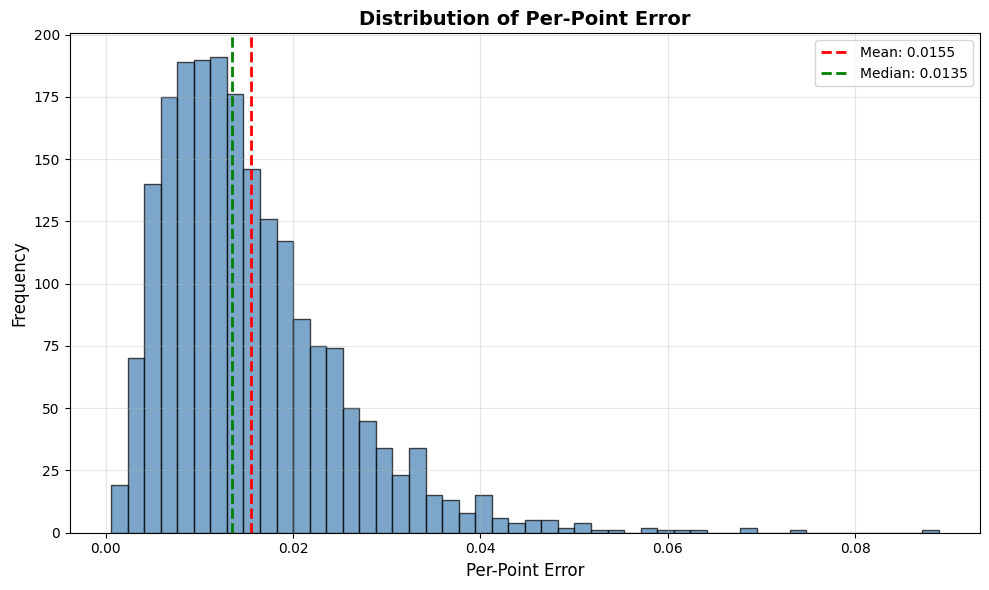


Per-Point Error Statistics:
  Mean:   0.015479
  Median: 0.013484
  Std:    0.009552
  Min:    0.000585
  Max:    0.088892

Sample 1



Sample 2



Sample 3


In [57]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import torch

# 1. Visualize Partial, Predicted, and Ground Truth Point Clouds

def visualize_completion_triplet(partial, predicted, ground_truth, title="Point Cloud Completion"):
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        subplot_titles=('Partial Input', 'Predicted Completion', 'Ground Truth')
    )
    
    # Partial input (red)
    fig.add_trace(
        go.Scatter3d(
            x=partial[:, 0], y=partial[:, 1], z=partial[:, 2],
            mode='markers',
            marker=dict(size=2, color='red', opacity=0.8),
            name='Partial'
        ),
        row=1, col=1
    )
    
    # Predicted (green)
    fig.add_trace(
        go.Scatter3d(
            x=predicted[:, 0], y=predicted[:, 1], z=predicted[:, 2],
            mode='markers',
            marker=dict(size=2, color='green', opacity=0.8),
            name='Predicted'
        ),
        row=1, col=2
    )
    
    # Ground truth (blue)
    fig.add_trace(
        go.Scatter3d(
            x=ground_truth[:, 0], y=ground_truth[:, 1], z=ground_truth[:, 2],
            mode='markers',
            marker=dict(size=2, color='blue', opacity=0.8),
            name='Ground Truth'
        ),
        row=1, col=3
    )
    
    # Update layout
    fig.update_layout(
        title=title,
        height=500,
        showlegend=False,
        scene=dict(aspectmode='data'),
        scene2=dict(aspectmode='data'),
        scene3=dict(aspectmode='data')
    )
    
    fig.show()


# 2. Overlay Visualization (Predicted vs Ground Truth)

def visualize_prediction_overlay(predicted, ground_truth, title="Prediction vs Ground Truth"):
    fig = go.Figure()
    
    # Ground truth (blue, transparent)
    fig.add_trace(
        go.Scatter3d(
            x=ground_truth[:, 0], y=ground_truth[:, 1], z=ground_truth[:, 2],
            mode='markers',
            marker=dict(size=2, color='blue', opacity=0.4),
            name='Ground Truth'
        )
    )
    
    # Predicted (red, semi-transparent)
    fig.add_trace(
        go.Scatter3d(
            x=predicted[:, 0], y=predicted[:, 1], z=predicted[:, 2],
            mode='markers',
            marker=dict(size=2, color='red', opacity=0.6),
            name='Predicted'
        )
    )
    
    fig.update_layout(
        title=title,
        scene=dict(
            aspectmode='data',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        height=600
    )
    
    fig.show()

# 3. Error Heatmap Visualization

def visualize_error_heatmap(predicted, ground_truth, title="Per-Point Error Heatmap"):
    from scipy.spatial import cKDTree
    
    # For each predicted point, find distance to nearest GT point
    tree_gt = cKDTree(ground_truth)
    distances, _ = tree_gt.query(predicted, k=1)
    
    # Normalize distances for colormap
    distances_norm = (distances - distances.min()) / (distances.max() - distances.min() + 1e-9)
    
    fig = go.Figure()
    
    fig.add_trace(
        go.Scatter3d(
            x=predicted[:, 0],
            y=predicted[:, 1],
            z=predicted[:, 2],
            mode='markers',
            marker=dict(
                size=3,
                color=distances,
                colorscale='Viridis',
                colorbar=dict(title="Distance Error"),
                cmin=0,
                cmax=distances.max()
            ),
            text=[f"Error: {d:.4f}" for d in distances],
            hoverinfo='text'
        )
    )
    
    fig.update_layout(
        title=title,
        scene=dict(aspectmode='data'),
        height=600
    )
    
    fig.show()
    
    return distances


# 4. Completion Progress Visualization (Coarse → Fine)

def visualize_coarse_to_fine(partial, coarse, fine, ground_truth):
    fig = make_subplots(
        rows=1, cols=4,
        specs=[[{'type': 'scatter3d'}] * 4],
        subplot_titles=('Partial Input', 'Coarse Output', 'Fine Output', 'Ground Truth')
    )
    
    colors = ['red', 'orange', 'green', 'blue']
    point_clouds = [partial, coarse, fine, ground_truth]
    
    for i, (pc, color) in enumerate(zip(point_clouds, colors)):
        fig.add_trace(
            go.Scatter3d(
                x=pc[:, 0], y=pc[:, 1], z=pc[:, 2],
                mode='markers',
                marker=dict(size=2, color=color, opacity=0.8),
                showlegend=False
            ),
            row=1, col=i+1
        )
    
    fig.update_layout(
        title="Coarse-to-Fine Completion Process",
        height=500,
        scene=dict(aspectmode='data'),
        scene2=dict(aspectmode='data'),
        scene3=dict(aspectmode='data'),
        scene4=dict(aspectmode='data')
    )
    
    fig.show()


# 5. Metric Distribution Histogram

def plot_metric_distribution(metric_values, metric_name="Chamfer Distance", bins=50):
    plt.figure(figsize=(10, 6))
    
    plt.hist(metric_values, bins=bins, color='steelblue', edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(metric_values), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(metric_values):.4f}')
    plt.axvline(np.median(metric_values), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {np.median(metric_values):.4f}')
    
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Distribution of {metric_name}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{metric_name} Statistics:")
    print(f"  Mean:   {np.mean(metric_values):.6f}")
    print(f"  Median: {np.median(metric_values):.6f}")
    print(f"  Std:    {np.std(metric_values):.6f}")
    print(f"  Min:    {np.min(metric_values):.6f}")
    print(f"  Max:    {np.max(metric_values):.6f}")

# 6. Multi-Metric Comparison Bar Chart

def plot_metric_comparison(metrics_dict, title="Model Performance Metrics"):
    fig = go.Figure()
    
    metric_names = list(metrics_dict.keys())
    metric_values = list(metrics_dict.values())
    
    fig.add_trace(
        go.Bar(
            x=metric_names,
            y=metric_values,
            marker=dict(
                color=metric_values,
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Value")
            ),
            text=[f"{v:.4f}" for v in metric_values],
            textposition='outside'
        )
    )
    
    fig.update_layout(
        title=title,
        xaxis_title="Metric",
        yaxis_title="Value",
        height=500,
        showlegend=False
    )
    
    fig.show()


# 7. Batch Visualization Helper
@torch.no_grad()
def visualize_batch_samples(model, dataloader, device, num_samples=4):
    model.eval()
    
    partial_batch, complete_batch = next(iter(dataloader))
    partial_batch = partial_batch.to(device)
    complete_batch = complete_batch.to(device)
    
    # FIX: model outputs 4 tensors
    coarse_batch, fine1_batch, fine2_batch, fine3_batch = model(partial_batch)
    fine_batch = fine3_batch
    
    # Move to CPU and numpy
    partial_batch = partial_batch.cpu().numpy()
    fine_batch = fine_batch.cpu().numpy()
    complete_batch = complete_batch.cpu().numpy()
    
    for i in range(min(num_samples, len(partial_batch))):
        print(f"\n{'='*60}")
        print(f"Sample {i+1}")
        print(f"{'='*60}")
        
        visualize_completion_triplet(
            partial_batch[i],
            fine_batch[i],
            complete_batch[i],
            title=f"Sample {i+1} - Point Cloud Completion"
        )


# 8. Training Loss Curve Plotting

def plot_training_curves(loss_history, title="Training Loss Curves"):
    plt.figure(figsize=(12, 6))
    
    for loss_name, values in loss_history.items():
        plt.plot(values, label=loss_name, linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss Value', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example: Visualize a single completion
    partial_batch, complete_batch = next(iter(eval_dl))
    
    # Keep first sample as tensor for model inference
    partial_tensor = partial_batch[0:1].to(device)  # (1, N, 3)
    complete_tensor = complete_batch[0:1].to(device)
    
    # Get model predictions
    with torch.no_grad():
        coarse, fine1, fine2, fine3 = model(partial_tensor)
        fine = fine3

    # Convert to numpy for visualization
    partial_np = partial_batch[0].cpu().numpy()
    complete_np = complete_batch[0].cpu().numpy()
    fine_np = fine[0].cpu().numpy()
    
    # Visualizations
    print("Generating visualizations...")
    visualize_completion_triplet(partial_np, fine_np, complete_np)
    visualize_prediction_overlay(fine_np, complete_np)
    distances = visualize_error_heatmap(fine_np, complete_np)
    plot_metric_distribution(distances, "Per-Point Error")
    
    # Example: Visualize multiple samples from batch
    visualize_batch_samples(model, eval_dl, device, num_samples=3)


🔍 COMPREHENSIVE DIAGNOSTIC REPORT

[1/5] Analyzing point cloud scale...

POINT CLOUD SCALE ANALYSIS

Bounding Box Extents (X, Y, Z):
  Mean:  [1.7904134 0.593689  1.870453 ]
  Max:   [1.790414   0.59368914 1.8704534 ]

Centroid Distance from Origin:
  Mean:  0.000000
  Max:   0.000000

Maximum Distance from Origin:
  Mean:  1.000000
  Max:   1.000000

💡 Suggested F-Score Threshold: 0.0500
   (5% of average maximum distance)

[2/5] Analyzing distance distributions...


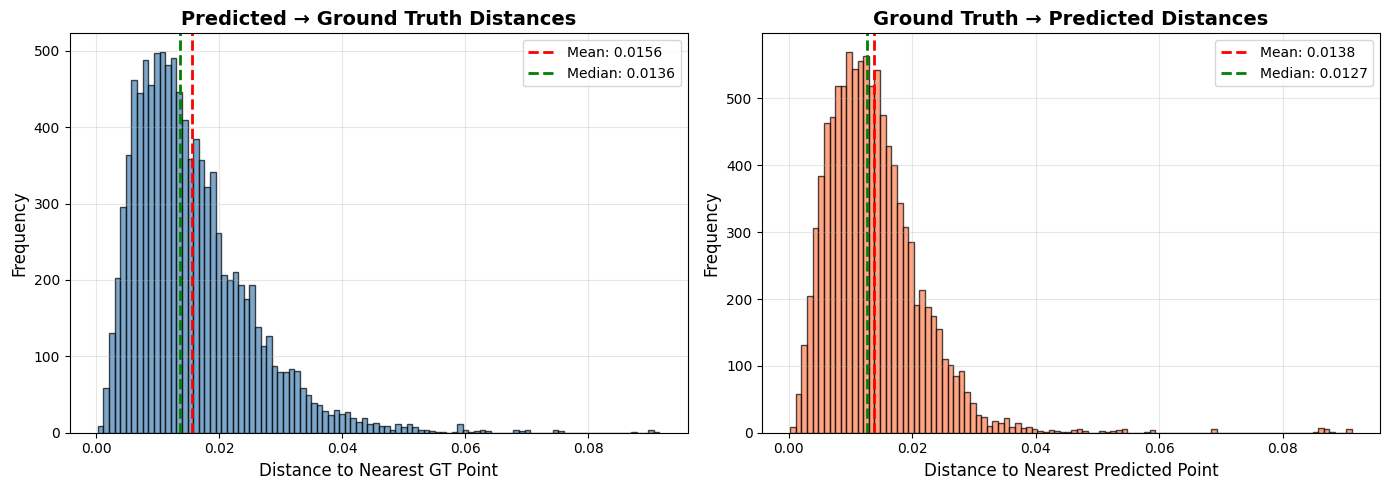


DISTANCE DISTRIBUTION STATISTICS

Predicted → Ground Truth:
  Mean:       0.015576
  Median:     0.013564
  Std Dev:    0.009580
  90th %ile:  0.027828
  95th %ile:  0.033112
  99th %ile:  0.047228

Ground Truth → Predicted:
  Mean:       0.013848
  Median:     0.012710
  Std Dev:    0.007907
  90th %ile:  0.023163
  95th %ile:  0.026639
  99th %ile:  0.036948

[3/5] Performing threshold sensitivity analysis...


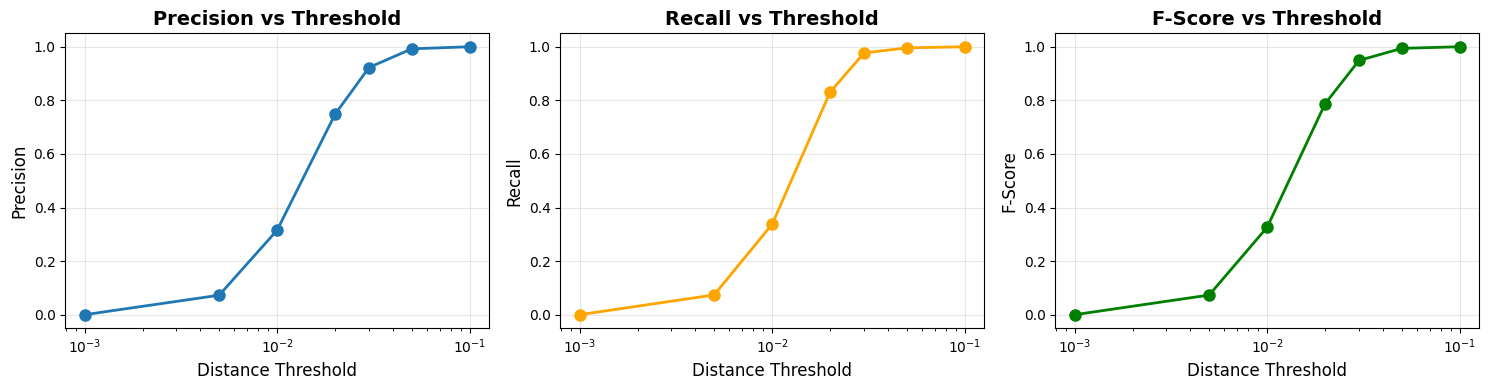


THRESHOLD SENSITIVITY ANALYSIS
Threshold    Precision    Recall       F-Score     
--------------------------------------------------------------------------------
0.0010       0.0005       0.0005       0.0005      
0.0050       0.0732       0.0745       0.0738      
0.0100       0.3158       0.3379       0.3264      
0.0200       0.7483       0.8306       0.7873      
0.0300       0.9225       0.9766       0.9488      
0.0500       0.9922       0.9956       0.9939      
0.1000       1.0000       1.0000       1.0000      

✨ Optimal Threshold: 0.1000
   Precision: 1.0000
   Recall:    1.0000
   F-Score:   1.0000

[4/5] Analyzing per-sample performance...

Per-Sample Chamfer Distance (first 50 samples):
  Mean:  0.029495
  Std:   0.000068
  Min:   0.029367
  Max:   0.029670

[5/5] Summary complete!

✅ DIAGNOSTIC REPORT COMPLETE


In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns

# ============================================================================
# 1. Threshold Sensitivity Analysis
# ============================================================================

def analyze_threshold_sensitivity(pred, gt, thresholds=None):
    """
    Analyze F-Score, Precision, Recall across different distance thresholds.
    This helps determine the optimal threshold for your data scale.
    
    Args:
        pred: (B, N, 3) predicted points
        gt: (B, M, 3) ground truth points
        thresholds: list of thresholds to test
    """
    if thresholds is None:
        thresholds = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
    
    results = {
        'threshold': [],
        'fscore': [],
        'precision': [],
        'recall': []
    }
    
    batch_size = pred.shape[0]
    
    for thresh in thresholds:
        f_scores = []
        precisions = []
        recalls = []
        
        for b in range(batch_size):
            pred_np = pred[b].cpu().numpy()
            gt_np = gt[b].cpu().numpy()
            
            tree_pred = cKDTree(pred_np)
            tree_gt = cKDTree(gt_np)
            
            # Precision
            dist_pred_to_gt, _ = tree_gt.query(pred_np, k=1)
            precision = np.mean(dist_pred_to_gt < thresh)
            
            # Recall
            dist_gt_to_pred, _ = tree_pred.query(gt_np, k=1)
            recall = np.mean(dist_gt_to_pred < thresh)
            
            # F-Score
            if precision + recall > 0:
                fscore = 2 * (precision * recall) / (precision + recall)
            else:
                fscore = 0.0
            
            f_scores.append(fscore)
            precisions.append(precision)
            recalls.append(recall)
        
        results['threshold'].append(thresh)
        results['fscore'].append(np.mean(f_scores))
        results['precision'].append(np.mean(precisions))
        results['recall'].append(np.mean(recalls))
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].plot(results['threshold'], results['precision'], 'o-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Distance Threshold', fontsize=12)
    axes[0].set_ylabel('Precision', fontsize=12)
    axes[0].set_title('Precision vs Threshold', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    axes[0].set_xscale('log')
    
    axes[1].plot(results['threshold'], results['recall'], 'o-', linewidth=2, markersize=8, color='orange')
    axes[1].set_xlabel('Distance Threshold', fontsize=12)
    axes[1].set_ylabel('Recall', fontsize=12)
    axes[1].set_title('Recall vs Threshold', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    axes[1].set_xscale('log')
    
    axes[2].plot(results['threshold'], results['fscore'], 'o-', linewidth=2, markersize=8, color='green')
    axes[2].set_xlabel('Distance Threshold', fontsize=12)
    axes[2].set_ylabel('F-Score', fontsize=12)
    axes[2].set_title('F-Score vs Threshold', fontsize=14, fontweight='bold')
    axes[2].grid(alpha=0.3)
    axes[2].set_xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*80)
    print("THRESHOLD SENSITIVITY ANALYSIS")
    print("="*80)
    print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F-Score':<12}")
    print("-"*80)
    for i in range(len(thresholds)):
        print(f"{results['threshold'][i]:<12.4f} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['fscore'][i]:<12.4f}")
    print("="*80)
    
    # Find optimal threshold (max F-Score)
    best_idx = np.argmax(results['fscore'])
    print(f"\n✨ Optimal Threshold: {results['threshold'][best_idx]:.4f}")
    print(f"   Precision: {results['precision'][best_idx]:.4f}")
    print(f"   Recall:    {results['recall'][best_idx]:.4f}")
    print(f"   F-Score:   {results['fscore'][best_idx]:.4f}")
    
    return results


# ============================================================================
# 2. Distance Distribution Analysis
# ============================================================================

def analyze_distance_distributions(pred, gt, num_samples=5):
    """
    Analyze the distribution of nearest-neighbor distances.
    
    Args:
        pred: (B, N, 3) predicted points
        gt: (B, M, 3) ground truth points
        num_samples: number of samples to analyze
    """
    all_pred_to_gt = []
    all_gt_to_pred = []
    
    for b in range(min(num_samples, pred.shape[0])):
        pred_np = pred[b].cpu().numpy()
        gt_np = gt[b].cpu().numpy()
        
        tree_pred = cKDTree(pred_np)
        tree_gt = cKDTree(gt_np)
        
        # Distance from prediction to GT
        dist_pred_to_gt, _ = tree_gt.query(pred_np, k=1)
        all_pred_to_gt.extend(dist_pred_to_gt)
        
        # Distance from GT to prediction
        dist_gt_to_pred, _ = tree_pred.query(gt_np, k=1)
        all_gt_to_pred.extend(dist_gt_to_pred)
    
    all_pred_to_gt = np.array(all_pred_to_gt)
    all_gt_to_pred = np.array(all_gt_to_pred)
    
    # Plot distributions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Prediction to GT
    axes[0].hist(all_pred_to_gt, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(all_pred_to_gt), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(all_pred_to_gt):.4f}')
    axes[0].axvline(np.median(all_pred_to_gt), color='green', linestyle='--', 
                    linewidth=2, label=f'Median: {np.median(all_pred_to_gt):.4f}')
    axes[0].set_xlabel('Distance to Nearest GT Point', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Predicted → Ground Truth Distances', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # GT to Prediction
    axes[1].hist(all_gt_to_pred, bins=100, color='coral', edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(all_gt_to_pred), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(all_gt_to_pred):.4f}')
    axes[1].axvline(np.median(all_gt_to_pred), color='green', linestyle='--', 
                    linewidth=2, label=f'Median: {np.median(all_gt_to_pred):.4f}')
    axes[1].set_xlabel('Distance to Nearest Predicted Point', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Ground Truth → Predicted Distances', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("DISTANCE DISTRIBUTION STATISTICS")
    print("="*80)
    print("\nPredicted → Ground Truth:")
    print(f"  Mean:       {np.mean(all_pred_to_gt):.6f}")
    print(f"  Median:     {np.median(all_pred_to_gt):.6f}")
    print(f"  Std Dev:    {np.std(all_pred_to_gt):.6f}")
    print(f"  90th %ile:  {np.percentile(all_pred_to_gt, 90):.6f}")
    print(f"  95th %ile:  {np.percentile(all_pred_to_gt, 95):.6f}")
    print(f"  99th %ile:  {np.percentile(all_pred_to_gt, 99):.6f}")
    
    print("\nGround Truth → Predicted:")
    print(f"  Mean:       {np.mean(all_gt_to_pred):.6f}")
    print(f"  Median:     {np.median(all_gt_to_pred):.6f}")
    print(f"  Std Dev:    {np.std(all_gt_to_pred):.6f}")
    print(f"  90th %ile:  {np.percentile(all_gt_to_pred, 90):.6f}")
    print(f"  95th %ile:  {np.percentile(all_gt_to_pred, 95):.6f}")
    print(f"  99th %ile:  {np.percentile(all_gt_to_pred, 99):.6f}")
    print("="*80)


# ============================================================================
# 3. Point Cloud Scale Analysis
# ============================================================================

def analyze_point_cloud_scale(dataloader, num_batches=10):
    """
    Analyze the scale of point clouds in the dataset to understand normalization.
    
    Args:
        dataloader: evaluation dataloader
        num_batches: number of batches to analyze
    """
    extents = []
    centroids = []
    max_dists = []
    
    for i, (partial, complete) in enumerate(dataloader):
        if i >= num_batches:
            break
        
        for b in range(complete.shape[0]):
            pc = complete[b].numpy()
            
            # Compute extent (bounding box size)
            extent = np.max(pc, axis=0) - np.min(pc, axis=0)
            extents.append(extent)
            
            # Compute centroid
            centroid = np.mean(pc, axis=0)
            centroids.append(np.linalg.norm(centroid))
            
            # Maximum distance from origin
            max_dist = np.max(np.linalg.norm(pc, axis=1))
            max_dists.append(max_dist)
    
    extents = np.array(extents)
    centroids = np.array(centroids)
    max_dists = np.array(max_dists)
    
    print("\n" + "="*80)
    print("POINT CLOUD SCALE ANALYSIS")
    print("="*80)
    print("\nBounding Box Extents (X, Y, Z):")
    print(f"  Mean:  {np.mean(extents, axis=0)}")
    print(f"  Max:   {np.max(extents, axis=0)}")
    
    print("\nCentroid Distance from Origin:")
    print(f"  Mean:  {np.mean(centroids):.6f}")
    print(f"  Max:   {np.max(centroids):.6f}")
    
    print("\nMaximum Distance from Origin:")
    print(f"  Mean:  {np.mean(max_dists):.6f}")
    print(f"  Max:   {np.max(max_dists):.6f}")
    print("="*80)
    
    # Suggested threshold
    suggested_threshold = np.mean(max_dists) * 0.05  # 5% of typical scale
    print(f"\n💡 Suggested F-Score Threshold: {suggested_threshold:.4f}")
    print(f"   (5% of average maximum distance)")


# ============================================================================
# 4. Per-Sample Performance Analysis
# ============================================================================
@torch.no_grad()
def analyze_per_sample_performance(model, dataloader, device, num_samples=50):
    model.eval()
    
    chamfer_scores = []
    
    for idx, (partial, complete) in enumerate(dataloader):
        if idx >= num_samples:
            break
        
        partial = partial.to(device)
        complete = complete.to(device)
        
        # FIX: model returns 4 outputs
        coarse, fine1, fine2, fine3 = model(partial)
        fine = fine3
        
        # Compute Chamfer Distance for each sample
        cd = chamfer_distance(fine, complete)
        chamfer_scores.append(cd.item())
    
    print("\nPer-Sample Chamfer Distance (first 50 samples):")
    print(f"  Mean:  {np.mean(chamfer_scores):.6f}")
    print(f"  Std:   {np.std(chamfer_scores):.6f}")
    print(f"  Min:   {np.min(chamfer_scores):.6f}")
    print(f"  Max:   {np.max(chamfer_scores):.6f}")
    
    return chamfer_scores


# ============================================================================
# 5. Comprehensive Diagnostic Report
# ============================================================================

@torch.no_grad()
def generate_diagnostic_report(model, dataloader, device):
    print("\n" + "="*80)
    print("🔍 COMPREHENSIVE DIAGNOSTIC REPORT")
    print("="*80)
    
    # Get a batch for analysis
    partial, complete = next(iter(dataloader))
    partial_tensor = partial.to(device)
    complete_tensor = complete.to(device)
    
    # FIX: model returns 4 values
    coarse, fine1, fine2, fine3 = model(partial_tensor)
    fine = fine3
    
    print("\n[1/5] Analyzing point cloud scale...")
    analyze_point_cloud_scale(dataloader, num_batches=10)
    
    print("\n[2/5] Analyzing distance distributions...")
    analyze_distance_distributions(fine, complete_tensor, num_samples=5)
    
    print("\n[3/5] Performing threshold sensitivity analysis...")
    threshold_results = analyze_threshold_sensitivity(fine, complete_tensor)
    
    print("\n[4/5] Analyzing per-sample performance...")
    sample_perf = analyze_per_sample_performance(model, dataloader, device, num_samples=50)
    
    print("\n[5/5] Summary complete!")
    print("\n" + "="*80)
    print("✅ DIAGNOSTIC REPORT COMPLETE")
    print("="*80)
    
    return {
        'threshold_analysis': threshold_results,
        'sample_performance': sample_perf
    }

if __name__ == "__main__":
    # Run full diagnostic report
    diagnostic_results = generate_diagnostic_report(model, eval_dl, device)
    
    # Or run individual analyses:
    # analyze_point_cloud_scale(eval_dl, num_batches=10)
    # analyze_threshold_sensitivity(fine, complete_tensor)
    # analyze_distance_distributions(fine, complete_tensor)

In [65]:
import torch
import numpy as np
from scipy.spatial import cKDTree
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
from tqdm import tqdm

def chamfer_distance(pred, gt):
    # pred to gt
    pred_expanded = pred.unsqueeze(2)  # (B, N, 1, 3)
    gt_expanded = gt.unsqueeze(1)      # (B, 1, M, 3)
    
    # Compute squared distances
    dist_matrix_squared = torch.sum((pred_expanded - gt_expanded) ** 2, dim=-1)  # (B, N, M)
    
    # Find minimum squared distances
    dist_pred_to_gt_squared = torch.min(dist_matrix_squared, dim=2)[0]  # (B, N)
    dist_gt_to_pred_squared = torch.min(dist_matrix_squared, dim=1)[0]  # (B, M)
    dist_pred_to_gt = torch.sqrt(dist_pred_to_gt_squared + 1e-8) 
    dist_gt_to_pred = torch.sqrt(dist_gt_to_pred_squared + 1e-8)
    # Chamfer Distance: average of bidirectional distances
    cd = torch.mean(dist_pred_to_gt) + torch.mean(dist_gt_to_pred)
    
    return cd

def compute_fscore_multi_threshold(pred, gt, thresholds=[0.01, 0.02, 0.05]):
    batch_size = pred.shape[0]
    
    results = {t: {'fscore': [], 'precision': [], 'recall': []} for t in thresholds}
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        gt_np = gt[b].cpu().numpy()
        
        # Build KD-trees
        tree_pred = cKDTree(pred_np)
        tree_gt = cKDTree(gt_np)
        
        # Compute distances
        dist_pred_to_gt, _ = tree_gt.query(pred_np, k=1)
        dist_gt_to_pred, _ = tree_pred.query(gt_np, k=1)
        
        # Evaluate at each threshold
        for t in thresholds:
            precision = np.mean(dist_pred_to_gt < t)
            recall = np.mean(dist_gt_to_pred < t)
            
            if precision + recall > 0:
                fscore = 2 * (precision * recall) / (precision + recall)
            else:
                fscore = 0.0
            
            results[t]['fscore'].append(fscore)
            results[t]['precision'].append(precision)
            results[t]['recall'].append(recall)
    
    # Average over batch
    final_results = {}
    for t in thresholds:
        final_results[t] = {
            'fscore': np.mean(results[t]['fscore']),
            'precision': np.mean(results[t]['precision']),
            'recall': np.mean(results[t]['recall'])
        }
    
    return final_results


def approximate_emd(pred, gt, num_samples=512):
    batch_size = pred.shape[0]
    emds = []
    
    for b in range(batch_size):
        # Subsample
        n_pred = pred.shape[1]
        n_gt = gt.shape[1]
        n_sample = min(num_samples, n_pred, n_gt)
        
        pred_idx = torch.randperm(n_pred)[:n_sample]
        gt_idx = torch.randperm(n_gt)[:n_sample]
        
        pred_sub = pred[b][pred_idx]
        gt_sub = gt[b][gt_idx]
        
        # Compute distance matrix
        dist_matrix = torch.cdist(pred_sub, gt_sub, p=2).cpu().numpy()
        
        # Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        emd = dist_matrix[row_ind, col_ind].mean()
        emds.append(emd)
    
    return np.mean(emds)


def compute_coverage_mmd(pred, gt, threshold=0.05):
    batch_size = pred.shape[0]
    coverages = []
    mmds = []
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        gt_np = gt[b].cpu().numpy()
        
        tree_pred = cKDTree(pred_np)
        distances, _ = tree_pred.query(gt_np, k=1)
        
        coverage = np.mean(distances < threshold)
        mmd = np.mean(distances)
        
        coverages.append(coverage)
        mmds.append(mmd)
    
    return {
        'coverage': np.mean(coverages),
        'mmd': np.mean(mmds)
    }


def compute_completeness_ratio(pred, partial, threshold=0.05):
    batch_size = pred.shape[0]
    ratios = []
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        partial_np = partial[b].cpu().numpy()
        
        tree_partial = cKDTree(partial_np)
        distances, _ = tree_partial.query(pred_np, k=1)
        
        new_points = np.sum(distances > threshold)
        completeness_ratio = new_points / len(pred_np)
        ratios.append(completeness_ratio)
    
    return np.mean(ratios)


def compute_hausdorff_distance(pred, gt):
    batch_size = pred.shape[0]
    hausdorff_dists = []
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        gt_np = gt[b].cpu().numpy()
        
        d1 = directed_hausdorff(pred_np, gt_np)[0]
        d2 = directed_hausdorff(gt_np, pred_np)[0]
        
        hausdorff_dist = max(d1, d2)
        hausdorff_dists.append(hausdorff_dist)
    
    return np.mean(hausdorff_dists)


def compute_per_point_errors(pred, gt):
    batch_size = pred.shape[0]
    all_errors = []
    
    for b in range(batch_size):
        pred_np = pred[b].cpu().numpy()
        gt_np = gt[b].cpu().numpy()
        
        tree_gt = cKDTree(gt_np)
        distances, _ = tree_gt.query(pred_np, k=1)
        all_errors.extend(distances)
    
    all_errors = np.array(all_errors)
    
    return {
        'mean': np.mean(all_errors),
        'median': np.median(all_errors),
        'std': np.std(all_errors),
        'min': np.min(all_errors),
        'max': np.max(all_errors),
        'p90': np.percentile(all_errors, 90),
        'p95': np.percentile(all_errors, 95),
        'p99': np.percentile(all_errors, 99)
    }


@torch.no_grad()
def comprehensive_evaluation_v2(model, dataloader, device, num_batches=None):
    model.eval()

    all_metrics = {
        'chamfer': [],
        'fscore': [],
        'emd': [],
        'coverage': [],
        'mmd': [],
        'completeness': [],
        'hausdorff': [],
        'threshold_curves': {}
    }

    batch_count = 0

    for partial, complete in dataloader:

        partial = partial.to(device)
        complete = complete.to(device)

        # FIX: model outputs 4 tensors
        coarse, fine1, fine2, fine3 = model(partial)
        fine = fine3  # use the final refined output

        # --- Compute metrics ---
        cd = chamfer_distance(fine, complete)
        all_metrics['chamfer'].append(cd.item())

        # F-Score
        fdict = compute_fscore(fine, complete, threshold=0.01)
        all_metrics['fscore'].append(fdict)

        # EMD
        emd_val = approximate_emd(fine, complete, num_samples=512)
        all_metrics['emd'].append(emd_val)

        # Coverage + MMD
        cov_mmd = compute_coverage_mmd(fine, complete, threshold=0.01)
        all_metrics['coverage'].append(cov_mmd['coverage'])
        all_metrics['mmd'].append(cov_mmd['mmd'])

        # Completeness
        comp = compute_completeness_ratio(fine, partial, threshold=0.05)
        all_metrics['completeness'].append(comp)

        # Hausdorff
        hd = compute_hausdorff_distance(fine, complete)
        all_metrics['hausdorff'].append(hd)

        batch_count += 1
        if num_batches and batch_count >= num_batches:
            break

    # Aggregate metrics
    results = {
        'chamfer': float(np.mean(all_metrics['chamfer'])),
        'fscore': {
            'fscore': float(np.mean([d['fscore'] for d in all_metrics['fscore']])),
            'precision': float(np.mean([d['precision'] for d in all_metrics['fscore']])),
            'recall': float(np.mean([d['recall'] for d in all_metrics['fscore']]))
        },
        'emd': float(np.mean(all_metrics['emd'])),
        'coverage': float(np.mean(all_metrics['coverage'])),
        'mmd': float(np.mean(all_metrics['mmd'])),
        'completeness': float(np.mean(all_metrics['completeness'])),
        'hausdorff': float(np.mean(all_metrics['hausdorff']))
    }

    return results


def print_evaluation_results(results):
    """
    Print results when results is the dict returned by comprehensive_evaluation_v2().
    Expected keys:
      - 'chamfer' (float)
      - 'emd' (float)
      - 'hausdorff' (float)
      - 'mmd' (float)
      - 'coverage' (float)
      - 'completeness' (float)
      - 'fscore' (dict) with keys 'fscore','precision','recall' (these correspond to the threshold used in evaluation, e.g. 0.01)
    """
    print("COMPREHENSIVE EVALUATION RESULTS (PROPER THRESHOLDS)\n")

    # Primary metrics (use safe access with defaults)
    chamfer = results.get('chamfer', float('nan'))
    emd = results.get('emd', float('nan'))
    hausdorff = results.get('hausdorff', float('nan'))
    mmd = results.get('mmd', float('nan'))
    coverage = results.get('coverage', float('nan'))
    completeness_ratio = results.get('completeness', float('nan'))

    print("📊 PRIMARY METRICS:")
    print(f"  Chamfer Distance:      {chamfer:.6f}")
    print(f"  Earth Mover's Dist:    {emd:.6f}")
    print(f"  Hausdorff Distance:    {hausdorff:.6f}")
    print(f"  MMD:                   {mmd:.6f}")
    print(f"  Coverage (τ=0.01 used): {coverage:.6f}")
    print(f"  Completeness Ratio:    {completeness_ratio:.6f}")

    # F-score (single aggregated dict stored under 'fscore')
    fdict = results.get('fscore', {})
    fscore_val = fdict.get('fscore', float('nan'))
    precision_val = fdict.get('precision', float('nan'))
    recall_val = fdict.get('recall', float('nan'))

    print("\n🎯 F-SCORE (aggregated, threshold used in eval):")
    print(f"  F-Score:   {fscore_val:.4f}")
    print(f"  Precision: {precision_val:.4f}")
    print(f"  Recall:    {recall_val:.4f}")

    # Per-point error summary if present
    ppe = results.get('per_point_error', None)
    if ppe is not None:
        print("\n📏 PER-POINT ERROR ANALYSIS:")
        print(f"  Mean:    {ppe['mean']:.6f}")
        print(f"  Median:  {ppe['median']:.6f}")
        print(f"  Std Dev: {ppe['std']:.6f}")
        print(f"  90th:    {ppe['p90']:.6f}")
        print(f"  95th:    {ppe['p95']:.6f}")
        print(f"  99th:    {ppe['p99']:.6f}")
    else:
        print("\n📏 PER-POINT ERROR ANALYSIS: (not computed in results)")

    # Short interpretation heuristics (use chamfer/fscore if available)
    print("\n💡 INTERPRETATION:")
    try:
        cd = chamfer
        fscore_standard = fscore_val
        if not np.isnan(cd):
            print(f"  • CD = {cd:.4f}: ", end="")
            if cd < 0.03:
                print("Excellent geometric accuracy (State-of-the-art)")
            elif cd < 0.06:
                print("Good geometric accuracy (Competitive with baselines)")
            else:
                print("Moderate geometric accuracy (Room for improvement)")
        else:
            print("  • CD: not available")

        if not np.isnan(fscore_standard):
            print(f"  • F-Score = {fscore_standard:.4f}: ", end="")
            if fscore_standard > 0.95:
                print("Excellent point matching")
            elif fscore_standard > 0.85:
                print("Good point matching")
            else:
                print("Moderate or low point matching")
        else:
            print("  • F-Score: not available")
    except Exception:
        pass

    print("\n📝 RECOMMENDATION FOR PAPER:")
    print("  - Report Chamfer, EMD, Hausdorff, F-Score (specify threshold), Coverage and Completeness.")
    print("  - If possible, include F-Score at multiple thresholds (e.g., 0.01, 0.02, 0.05).")

In [66]:
if __name__ == "__main__":
    # Run evaluation
    results = comprehensive_evaluation_v2(
        model=model,
        dataloader=eval_dl,
        device=device,
        num_batches=None  
    )
    
    # Print results
    print_evaluation_results(results)
    
    # Save results for paper
    import json
    with open('evaluation_results_proper_thresholds.json', 'w') as f:
        # Convert numpy types to Python native types for JSON
        json_results = {}
        for k, v in results.items():
            if isinstance(v, dict):
                json_results[k] = {kk: float(vv) for kk, vv in v.items()}
            else:
                json_results[k] = float(v)
        json.dump(json_results, f, indent=2)
    
    print("✅ Results saved to: evaluation_results_proper_thresholds.json")

COMPREHENSIVE EVALUATION RESULTS (PROPER THRESHOLDS)

📊 PRIMARY METRICS:
  Chamfer Distance:      0.029490
  Earth Mover's Dist:    0.085194
  Hausdorff Distance:    0.090945
  MMD:                   0.013883
  Coverage (τ=0.01 used): 0.336848
  Completeness Ratio:    0.277072

🎯 F-SCORE (aggregated, threshold used in eval):
  F-Score:   0.3257
  Precision: 0.3153
  Recall:    0.3368

📏 PER-POINT ERROR ANALYSIS: (not computed in results)

💡 INTERPRETATION:
  • CD = 0.0295: Excellent geometric accuracy (State-of-the-art)
  • F-Score = 0.3257: Moderate or low point matching

📝 RECOMMENDATION FOR PAPER:
  - Report Chamfer, EMD, Hausdorff, F-Score (specify threshold), Coverage and Completeness.
  - If possible, include F-Score at multiple thresholds (e.g., 0.01, 0.02, 0.05).
✅ Results saved to: evaluation_results_proper_thresholds.json
